# NTDS - Project

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.spatial.distance import pdist, squareform
from scipy import stats
import seaborn as sns

# Network
import networkx as nx
from pygsp import graphs, filters, plotting

# Classification + ML
from networkx.algorithms import node_classification
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

%matplotlib inline

In [45]:
%load_ext autoreload
%autoreload 2

import helpers as hl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

In [2]:
data_folder = './data/BXD data-3/'

##### Genotype

In [3]:
df_genotype = pd.read_csv(data_folder + 'genotype_BXD.txt', delimiter ="\t", index_col='SNP').transpose()
df_genotype.index.name = 'BDX_strain'
df_genotype.head()

SNP,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298,rs51852623,rs31879829,rs36742481,...,rs47382998,rs13484107,rs3693969,DXMit223,rs31638776,rs31639754,rs46326766,rs31412493,rs31417520,UT-M-9461
BDX_strain,,,,,,,,,,,,,,,,,,,,,
B6D2F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,-1
D2B6F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-1,-1,-1,1
C57BL.6J,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
DBA.2J,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
BXD1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,1,1,-1


##### Phenotype

In [23]:
df_phenotype = pd.read_csv(data_folder + "Phenotype.txt", delimiter="\t", index_col='PhenoID').transpose() 
df_phenotype.index.name = 'BXD_strain'
print(df_phenotype.shape)

(97, 5092)


## Create network

#### Adjacency

In [11]:
# Adjacency for progeny strains only (remove P generations)
strains = df_genotype.index.to_list()[4:]
genotype_adjacency = hl.get_adjacency(df_genotype.loc[strains].to_numpy(), 'cosine', sigma=0.53, epsilon=0.27)

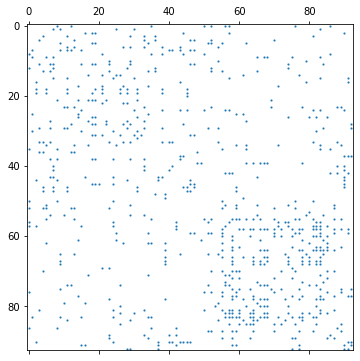

In [12]:
plt.subplots(figsize=(6,6))
plt.spy(genotype_adjacency, markersize=1)

#### Network

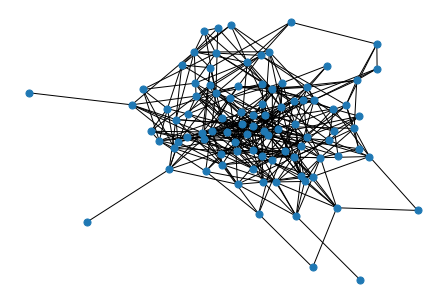

In [15]:
genotype_graph = nx.from_numpy_array(genotype_adjacency)
nx.draw(genotype_graph, node_size=50)

In [20]:
hl.graph_basic_stats(genotype_graph)

╒═════════════════════════════════════════════════╤════════╕
│ Number of nodes                                 │  93    │
├─────────────────────────────────────────────────┼────────┤
│ Number of edges                                 │ 373    │
├─────────────────────────────────────────────────┼────────┤
│ Graph density                                   │   8.72 │
├─────────────────────────────────────────────────┼────────┤
│ Average degree                                  │   8.02 │
├─────────────────────────────────────────────────┼────────┤
│ Number of connected components                  │   1    │
├─────────────────────────────────────────────────┼────────┤
│ Average clustering coefficient                  │   0.26 │
├─────────────────────────────────────────────────┼────────┤
│ Diameter of the network (longest shortest path) │   6    │
╘═════════════════════════════════════════════════╧════════╛


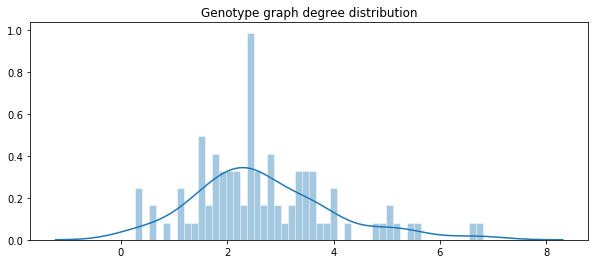

In [21]:
# Degree distribution
degrees = genotype_adjacency.sum(1)
deg_hist_normalization = np.ones(degrees.shape[0]) / degrees.shape[0]

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title('Genotype graph degree distribution')
sns.distplot(degrees, ax=ax, bins=50, kde=True, hist_kws=dict(edgecolor="w", linewidth=1))

## Classifier

#### Harmonic function (from nx) - w/o GSP

In [24]:
# Using a phenotype present on most strain: X63 (3 nans only)
df_phenotype.loc[df_phenotype['X63'].isnull()==True].index.to_list()

['BXD37', 'BXD41', 'BXD54']

In [29]:
# Discard unknown sample. Nope
labels = df_phenotype.loc[strains][['X63']] 
labels = labels.to_numpy().ravel()

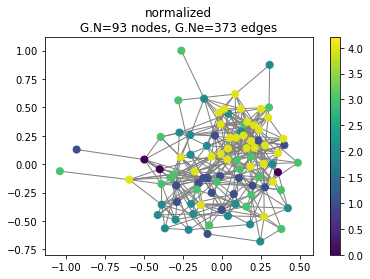

In [40]:
# Signal visualization
pygsp_graph = graphs.Graph(genotype_adjacency, 'normalized')
pygsp_graph.set_coordinates(kind='spring')
plotting.plot_signal(pygsp_graph, np.nan_to_num(labels, copy=True), backend=None, vertex_size=50)

In [27]:
nb_nodes = genotype_adjacency.shape[0]
train_mask, test_mask = hl.get_masks(nb_nodes, 0.1)

In [30]:
y_train = labels[train_mask]
y_test = labels[test_mask]

In [32]:
# Semi-supervised learning, assign training labels only
genotype_graph = nx.from_numpy_array(genotype_adjacency)

for node_number, node_value in zip(train_mask, y_train):
    genotype_graph.nodes[node_number]['label'] = node_value

In [38]:
# Classify remaining nodes
y_classification = node_classification.harmonic_function(genotype_graph)
y_hat = np.array(y_classification)[test_mask]

In [39]:
print('Accuracy: {:.2f}'.format(hl.compute_accuracy(y_test, y_hat)))

Accuracy: 0.67


#### Simple logistic regression - w/o GSP 

In [42]:
# build feature vector (seen as a multi-dimensional signal on the graph nodes)
# for now: [X62, X64, X4473, X152, X111, X546, X1012, X3820]
# we have 93 strains, i.e. 93 nodes
# So final feature vector (93x8)

feature_names = ['X62', 'X64', 'X4473', 'X152', 'X111', 'X546', 'X1012', 'X3820']

features = df_phenotype.loc[strains][['X62']].to_numpy()
for f in feature_names[1:]:
    new_feature = df_phenotype.loc[strains][[f]].to_numpy().ravel()
    features = np.c_[features, new_feature] 

print(features.shape)

(93, 8)


In [43]:
labels = df_phenotype.loc[strains][['X63']].to_numpy().ravel()
print(labels.shape)

(93,)


In [44]:
# Deal with nans 
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
X = imp.fit_transform(features)
y = imp.fit_transform(labels.reshape(-1,1))

logistic = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='auto')

accuracies = cross_val_score(logistic, X, y.ravel(), cv=5, scoring="accuracy")
print('Accuracy: {:.2f}'.format(np.mean(accuracies)))

Accuracy: 0.91


#### Simple logistic regression - with GSP 

In [46]:
laplacian = hl.compute_laplacian(genotype_adjacency, normalize=True)
lam, U = hl.spectral_decomposition(laplacian)
lam_max = np.max(lam)

In [48]:
alpha = 0.99 / lam_max

ideal_filter = 1 / (1 + alpha*lam)

order = 5
coeff = hl.fit_polynomial(lam, order, ideal_filter)
graph_filter = hl.polynomial_graph_filter(coeff, laplacian)

X_filtered = graph_filter @ X

In [49]:
logistic = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='auto')

accuracies = cross_val_score(logistic, X_filtered, y.ravel(), cv=5, scoring="accuracy")
print('Accuracy: {:.2f}'.format(np.mean(accuracies)))

Accuracy: 0.87


Moins bien mais essayer avec des features non-catégoriques!

#### Deep learning